# Automatic BSPF Eventplots

Creates automatic event plots based on catalog 

In [19]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.compute_adr_pfo import __compute_adr_pfo


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __process_xpfo(config, st, inv):

    ii_pfo = st.copy()

#     pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
#     ii_pfo.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo.detrend("demean")

    ## remove response
#     ii_pfo.remove_response(inventory=inv, 
#     #                        pre_filt=pre_filt, 
#                            output="VEL",
#     #                        water_level=60, 
#                            plot=False)

    ## taper 
    ii_pfo.taper(0.1)

    ## bandpass
    ii_filter = ii_pfo.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    ## adjust channel names
    for tr in ii_pfo:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")
    
    return ii_pfo

In [4]:
def __makeplot(config, st):

    
    st_in = st.copy()
    
    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st_in):
        
        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    del st_in
    return fig

In [5]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()
    
    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14
    
    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)
    
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

In [6]:
def __compute_values_for_analysis(st_in, event_in, magnitude, coincidencesum):
    
    print(event_in)
    
    st_in.sort()

    st_in.detrend("linear")
    
    out = []
    out.append(event_in)
    out.append(round(float(magnitude), 2))
    out.append(coincidencesum)
    
    for tr in st_in:
        out.append(max(tr.data))

    return out

## Configurations

In [20]:
config = {}

## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
config['outpath_figs'] = data_path+"BSPF/figures/triggered_all/"

## path for output data
config['outpath_data'] = data_path+"BSPF/data/" 

## blueSeis sensor (@200Hz)
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
config['seed_seismometer1'] = "II.PFO.10.BH*" 

## STS2 next to BlueSeis (@200Hz)
config['seed_seismometer2'] = "PY.PFOIX..HH*" 

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"
config['catalog'] = "BSPF_catalog_20221001_20230615_triggered.pkl"

## Event Info

In [8]:
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

events.reset_index(inplace=True)
events.rename(columns = {'index':'origin'}, inplace = True)

In [9]:
events

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,cosum,backazimuth,distances_km
0,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,0.00,2022-10-02T03:25:19.344538Z,4.0,19.364710,14.850966
1,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,132173.53,2022-10-03T16:08:19.219538Z,6.0,128.765512,55.472148
2,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,132173.53,2022-10-03T16:08:19.219538Z,6.0,128.765512,55.472148
3,2022-10-05 15:39:13.690,33.494500,-116.509500,12410.0,0.50,ml,303237.25,2022-10-05T15:39:17.944539Z,4.0,21.277323,13.825658
4,2022-10-07 22:45:05.470,33.041333,-116.354667,11790.0,3.47,mlr,501589.03,2022-10-07T22:45:15.894539Z,6.0,351.575554,63.835594
...,...,...,...,...,...,...,...,...,...,...,...
95,2023-05-24 19:11:52.210,33.952667,-116.645333,11420.0,2.22,ml,20274395.77,2023-05-24T19:11:59.335000Z,4.0,155.073931,41.815491
96,2023-05-31 23:27:27.570,33.950667,-116.642833,16340.0,2.35,ml,20894531.13,2023-05-31T23:27:34.805000Z,4.0,155.235515,41.517082
97,2023-06-04 04:43:02.890,33.140667,-116.526500,7720.0,3.16,ml,21172666.45,2023-06-04T04:43:11.320000Z,5.0,7.210330,52.543371
98,2023-06-07 06:03:42.030,33.965667,-116.946000,7240.0,2.58,ml,21436705.59,2023-06-07T06:03:52.075000Z,4.0,130.780515,60.123060


In [10]:
# __add_distances_and_backazimuth(config['tbeg'], config['tend'], events)

## RUN LOOP

 -> 0 2022-10-02 03:25:16.440000 
 -> sensitivity removed!
 -> response removed!
 -> continue computing ADR for 8 stations ...
24 Trace(s) in Stream:
II.PFO.10.BHZ | 2022-10-02T03:23:56.444538Z - 2022-10-02T03:28:36.419538Z | 40.0 Hz, 11200 samples
II.PFO.10.BHN | 2022-10-02T03:23:56.444538Z - 2022-10-02T03:28:36.419538Z | 40.0 Hz, 11200 samples
II.PFO.10.BHE | 2022-10-02T03:23:56.444538Z - 2022-10-02T03:28:36.419538Z | 40.0 Hz, 11200 samples
PY.BPH01..BHZ | 2022-10-02T03:23:56.446900Z - 2022-10-02T03:28:36.421900Z | 40.0 Hz, 11200 samples
PY.BPH01..BHN | 2022-10-02T03:23:56.446900Z - 2022-10-02T03:28:36.421900Z | 40.0 Hz, 11200 samples
PY.BPH01..BHE | 2022-10-02T03:23:56.446900Z - 2022-10-02T03:28:36.421900Z | 40.0 Hz, 11200 samples
PY.BPH06..BHZ | 2022-10-02T03:23:56.446900Z - 2022-10-02T03:28:36.421900Z | 40.0 Hz, 11200 samples
PY.BPH06..BHN | 2022-10-02T03:23:56.446900Z - 2022-10-02T03:28:36.421900Z | 40.0 Hz, 11200 samples
PY.BPH06..BHE | 2022-10-02T03:23:56.446900Z - 2022-10-02T0

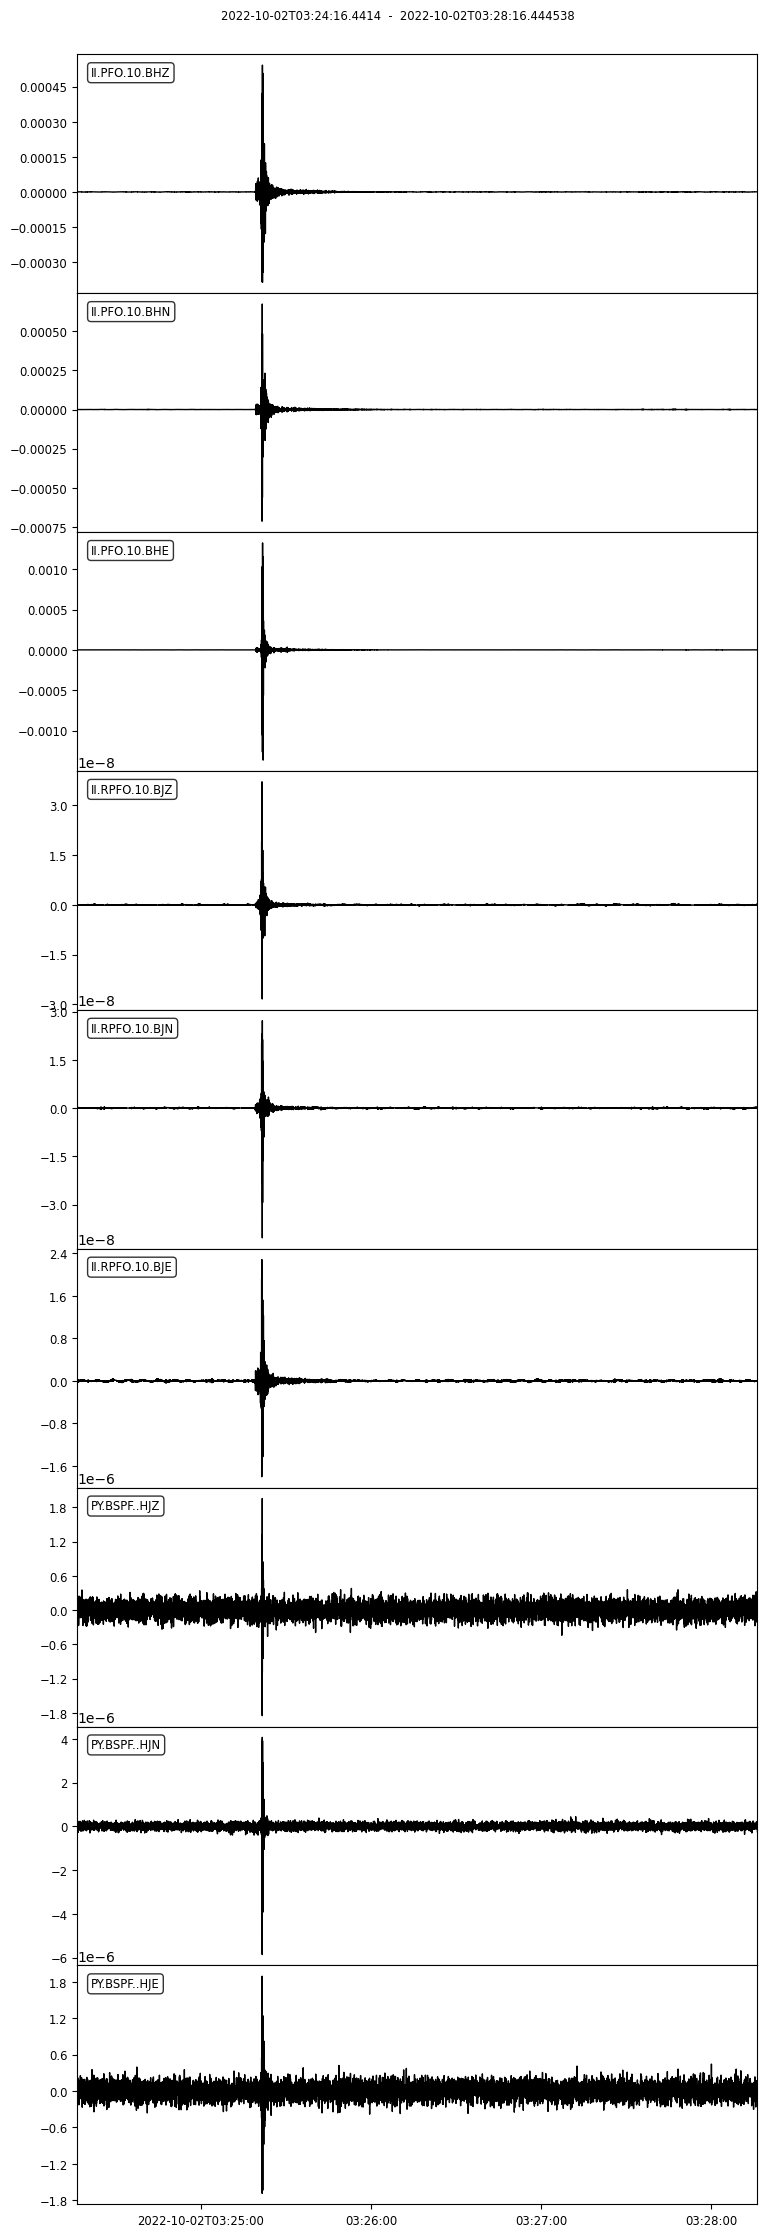

 -> 1 2022-10-03 16:08:09.970000 
 -> sensitivity removed!
 -> response removed!
 -> continue computing ADR for 8 stations ...
24 Trace(s) in Stream:
II.PFO.10.BHZ | 2022-10-03T16:06:49.994538Z - 2022-10-03T16:11:29.969538Z | 40.0 Hz, 11200 samples
II.PFO.10.BHN | 2022-10-03T16:06:49.994538Z - 2022-10-03T16:11:29.969538Z | 40.0 Hz, 11200 samples
II.PFO.10.BHE | 2022-10-03T16:06:49.994538Z - 2022-10-03T16:11:29.969538Z | 40.0 Hz, 11200 samples
PY.BPH01..BHZ | 2022-10-03T16:06:49.971900Z - 2022-10-03T16:11:29.946900Z | 40.0 Hz, 11200 samples
PY.BPH01..BHN | 2022-10-03T16:06:49.971900Z - 2022-10-03T16:11:29.946900Z | 40.0 Hz, 11200 samples
PY.BPH01..BHE | 2022-10-03T16:06:49.971900Z - 2022-10-03T16:11:29.946900Z | 40.0 Hz, 11200 samples
PY.BPH06..BHZ | 2022-10-03T16:06:49.971900Z - 2022-10-03T16:11:29.946900Z | 40.0 Hz, 11200 samples
PY.BPH06..BHN | 2022-10-03T16:06:49.971900Z - 2022-10-03T16:11:29.946900Z | 40.0 Hz, 11200 samples
PY.BPH06..BHE | 2022-10-03T16:06:49.971900Z - 2022-10-03T1

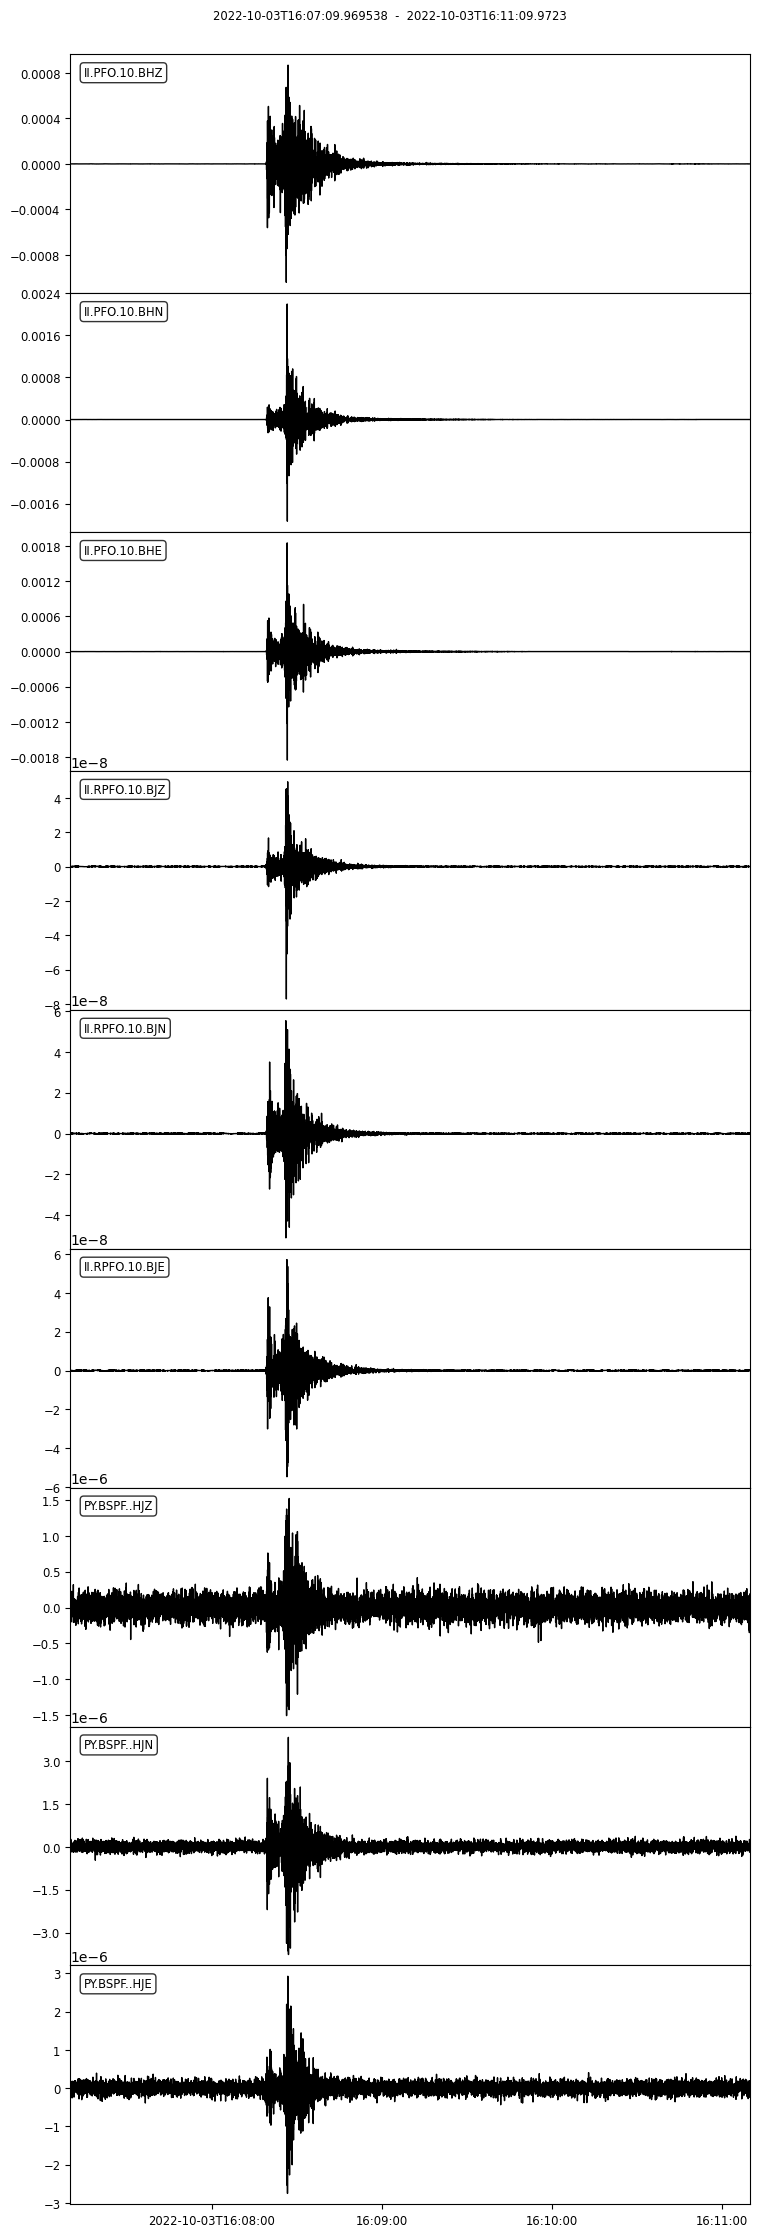

                  Torigin  Magnitude  CoincidenceSum   PFO_BHE   PFO_BHN  \
0 2022-10-02 03:25:16.440       1.49             4.0  0.001325  0.000674   
1 2022-10-03 16:08:09.970       3.01             6.0  0.001857  0.002194   

    PFO_BHZ      RPFO_BJE      RPFO_BJN      RPFO_BJZ  BSPF_HJE  BSPF_HJN  \
0  0.000542  2.281682e-08  2.715420e-08  3.708354e-08  0.000002  0.000004   
1  0.000869  5.706671e-08  5.523965e-08  4.933761e-08  0.000003  0.000004   

   BSPF_HJZ  
0  0.000002  
1  0.000002  
[]


In [36]:
global errors
errors = []

# for jj, ev in enumerate(tqdm(events.index)):
for jj, ev in enumerate([0,1]):

    print(f" -> {jj} {events.origin[jj]} ")
    
    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    filename=config['outpath_figs']+"raw/"+f"{event_name}_raw.png"
  
    ## check if file already exists
#     if os.path.isfile(filename):
#         print(f" -> file alread exits for {event_name}")
#         continue
    
    ## configuration adjustments
    config['title'] = f"{events.origin[jj]} UTC | M{events.magnitude[jj]}"
    config['tbeg'] = obs.UTCDateTime(str(events.origin[jj]))-60

    
    ## select appropriate seismometer
    if config['tbeg'].date < obs.UTCDateTime("2023-04-01"):
        config['seed_seismometer'] = config['seed_seismometer1']
        config['fmin'], config['fmax'] = 0.02, 18.0
    else:
        config['seed_seismometer'] = config['seed_seismometer2']
        config['fmin'], config['fmax'] = 0.02, 80.0
        
        
    ## select appropriate endtime
    if events.distances_km[jj] < 30:
        config['tend'] = obs.UTCDateTime(events.origin[jj])+30
    elif events.distances_km[jj] > 30 and events.distances_km[jj] < 100:
        config['tend'] = obs.UTCDateTime(events.origin[jj])+60
    else:
        config['tend'] = obs.UTCDateTime(events.origin[jj])+180
    
    ## same endtime for all
    config['tend'] = obs.UTCDateTime(events.origin[jj])+180
    
    
    ## load and process blueSeis data
    try:
        py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])
        
    except Exception as e:
        print(e)
        print(f" -> failed to request BSPF for event: {ev}")
        errors.append(f" -> failed to request BSPF for event: {ev}")
        continue
        
        
    ## load and process seismometer data
    try:        
        ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])
        
    except Exception as e:
        print(e)
        print(f" -> failed to request BSPF for event: {ev}")   
        continue

    if py_bspf0 is None or ii_pfo0 is None:
        continue
        
    ## processing data
    if ii_pfo0[0].stats.sampling_rate != py_bspf0[0].stats.sampling_rate:
        py_bspf0.resample(ii_pfo0[0].stats.sampling_rate)
        
        
    ## joining data
    st0 = py_bspf0
    st0 += ii_pfo0 
    
    
    ## compute ADR
    try:
        pfo_adr = __compute_adr_pfo(config['tbeg'], config['tend'], submask="optimal")
        st0 += pfo_adr
    except:
        print(" -> failed to compute ADR ...")
        
    st0 = st0.sort()
        
    ## processing data stream
    st = st0.copy() 
    st.detrend("linear")
    st.taper(0.01)
    st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)
    
    
    st.trim(config['tbeg'], config['tend'])
    st0.trim(config['tbeg'], config['tend'])
    
    ## store waveform data
    waveform_filename = f"{jj}_{str(events.origin[jj]).split('.')[0].replace('-','').replace(':','').replace(' ','_')}.mseed"
    st0.write(config['outpath_data']+waveform_filename, format="MSEED")
    
    ## compute analysis parameters
    if jj == 0:
        header = ["Torigin", "Magnitude", "CoincidenceSum"]; [header.append(f"{tr.stats.station}_{tr.stats.channel}") for tr in st0]
        out_df = pd.DataFrame(columns=header)
        
    out = __compute_values_for_analysis(st0, events.origin[jj], events.magnitude[jj], events.cosum[jj])
    out_df.loc[len(out_df)] = out   

    
    
    ## create eventname
    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    
    
    ## plotting figures    
    fig1 = st0.plot(equal_scale=False);
#     fig1 = st0.plot(equal_scale=False, show=False);

#     fig2 = __makeplot(config, st)

#     fig3 = __makeplotStreamSpectra2(st, config, fscale="linlin");
    
    ## saving figures
    fig1.savefig(config['outpath_figs']+"raw/"+f"{event_name}_raw.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

#     fig2.savefig(config['outpath_figs']+"filtered/"+f"{event_name}_filtered.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

#     fig3.savefig(config['outpath_figs']+"spectra/"+f"{event_name}_spectra.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## store amplitude values
out_df.to_pickle(config['outpath_data']+"amplitudes.pkl")

    
pprint(out_df)
pprint(errors)

## Testing Signal-to-Noise ratios

846960.874299
1182895.53437
621069.007621
8022.66207907
15817.671318
10834.6291022
32.3999584342
78.5461486484
12.9231490057


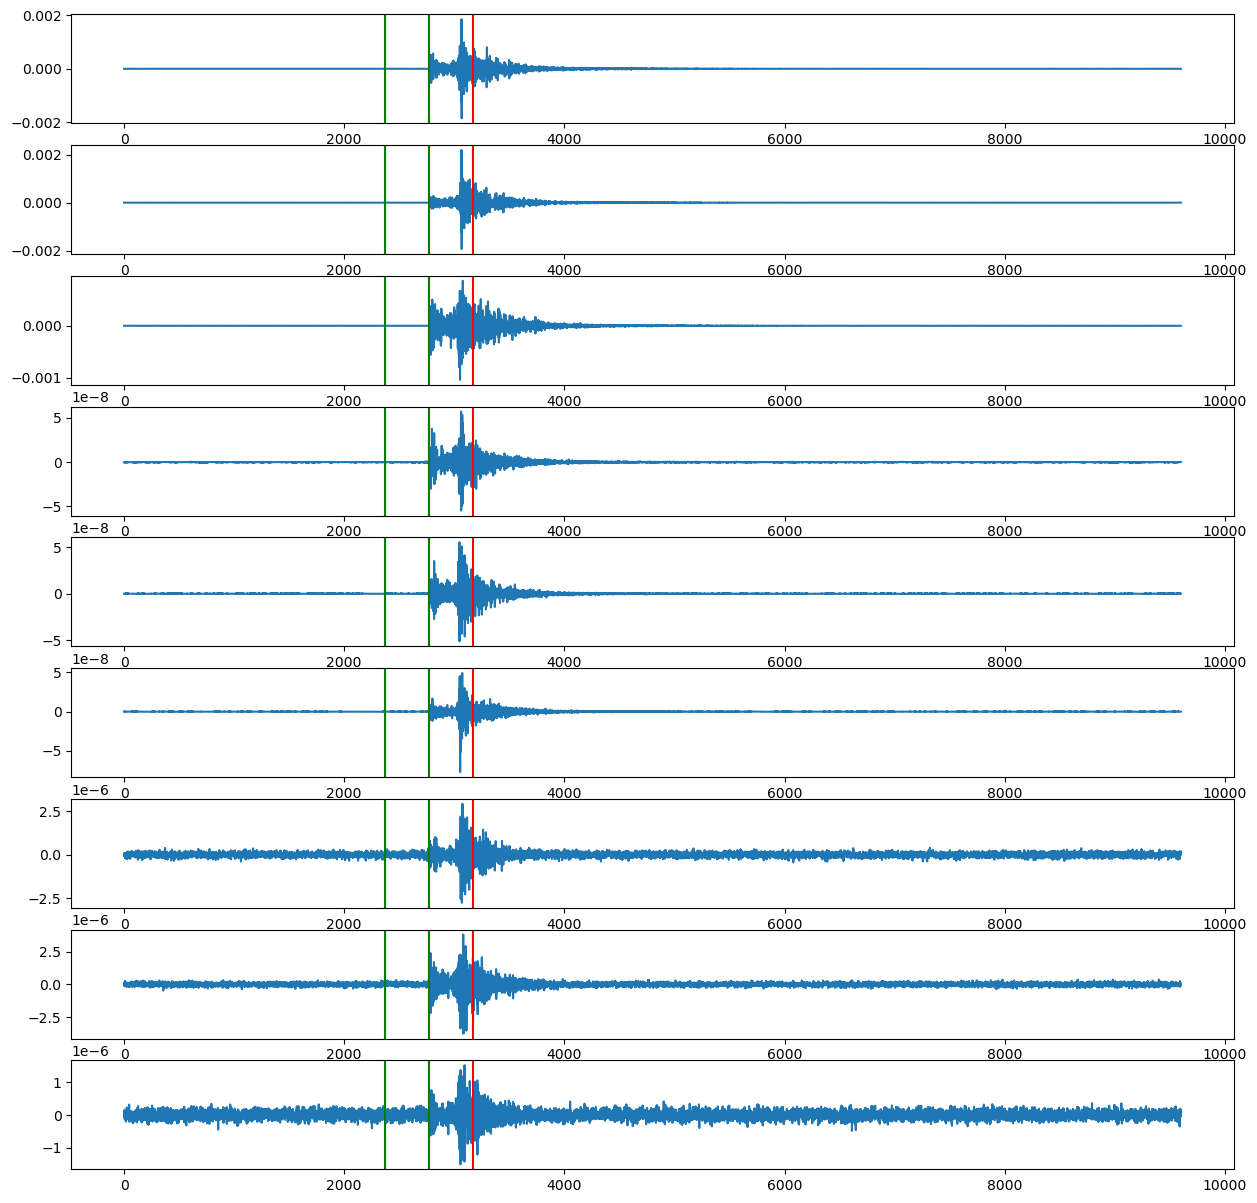

In [85]:
from numpy import nanmean

win_length_sec = 10 ## seconds

t_trigger = events.trigger_time[jj]
t_rel_sec = t_trigger-config['tbeg']

fig, ax = plt.subplots(len(st0),1, figsize=(15,15))

for i, tr in enumerate(st0):
    df = tr.stats.sampling_rate
    NN = int(df * win_length_sec)
    t_rel_spl = t_rel_sec*df
    
    
    noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
    signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)
    
    
    print(signal/noise)
    ax[i].plot(tr.data)
    

    ax[i].axvline(t_rel_spl, color="red")
    ax[i].axvline(t_rel_spl+NN, color="red")

    ax[i].axvline(t_rel_spl, color="g")
    ax[i].axvline(t_rel_spl-NN, color="g")

#     ax[i].axhline(y=noise, color="red", zorder=4)
#     ax[i].axhline(y=signal, color="red", zorder=4)
    